Задание для выполнения в классе: напишите функцию, которая принимает на вход имя файла .seg_G1 и пороговое значение ЧОТ (50 Гц по умолчанию) и возвращает два списка: в одном - положение каждого периода (т.е. его середина), во втором - значение ЧОТ в этом периоде.

In [ ]:
!wget https://pkholyavin.github.io/mastersprogramming/cta0001.seg_G1

In [1]:
from itertools import product
letters = "GBRY"
nums = "1234"
levels = [ch + num for num, ch in product(nums, letters)]
level_codes = [2 ** i for i in range(len(levels))]
code_to_level = {i: j for i, j in zip(level_codes, levels)}
level_to_code = {j: i for i, j in zip(level_codes, levels)}

In [2]:
def read_seg(filename: str, encoding: str = "utf-8-sig") -> tuple[dict, list[dict]]:
    with open(filename, encoding=encoding) as f:
        lines = [line.strip() for line in f.readlines()]

    # найдём границы секций в списке строк:
    header_start = lines.index("[PARAMETERS]") + 1
    data_start = lines.index("[LABELS]") + 1

    # прочитаем параметры
    params = {}
    for line in lines[header_start:data_start - 1]:
        key, value = line.split("=")
        params[key] = int(value)

    # прочитаем метки
    labels = []
    for line in lines[data_start:]:
        # если в строке нет запятых, значит, это не метка и метки закончились
        if line.count(",") < 2:
            break
        pos, level, name = line.split(",", maxsplit=2)
        label = {
            "position": int(pos) // params["BYTE_PER_SAMPLE"] // params["N_CHANNEL"],
            "level": code_to_level[int(level)],
            "name": name
        }
        labels.append(label)
    return params, labels

In [19]:
def get_f0(filename: str, min_f0: float = 50.0) -> tuple[list[float]]:
    params, labels = read_seg(filename)
    labels = labels[1:-1]  # уберём метки с названиями
    times, f0_values = [], []
    for left, right in zip(labels, labels[1:]):
        f0 = 1 / ((right["position"] - left["position"]) / params["SAMPLING_FREQ"])
        time = (right["position"] + left["position"]) / 2 / params["SAMPLING_FREQ"]
        times.append(time)
        if f0 < min_f0 or left["name"] == "0":  # обозначение в CORPRES
            f0_values.append(float("nan"))
        else:   
            f0_values.append(f0)
    return times, f0_values

Используем эту функцию для построения графика несглаженной ЧОТ:

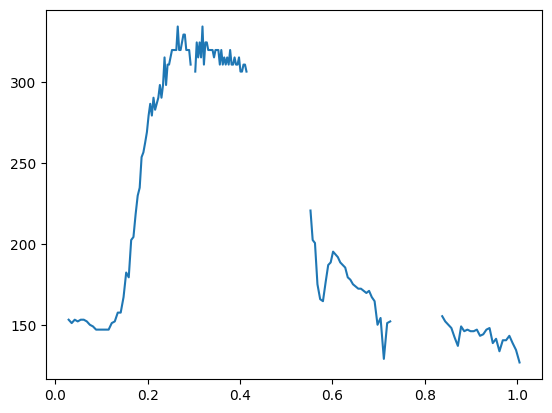

In [20]:
import matplotlib.pyplot as plt
times, f0_values = get_f0("cta0001.seg_G1")
plt.plot(times, f0_values)
plt.show()